# Introduction
The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.

# Objective 
1. Any correlation between genre and sales ?
2. Which are the top countries with the most sales ? 
3. Who are the top artist for each genre ?

Source: https://github.com/lerocha/chinook-database

# Table of Contents
1. [Introduction](#Introduction) 
2. [Data Exploration & General Observation](#Data-Exploration-&-General-Observation)
3. [Genre and Sales](#Genre-and-Sales)
4. [Country and Sales](#Country-and-Sales)
5. [Genre, Artist and Customers](#Genre,-Artist-and-Customers)
6. [Conclusion & Key Findings](#Conclusion-&-Key-Findings) 
7. [Reference](#Reference:)



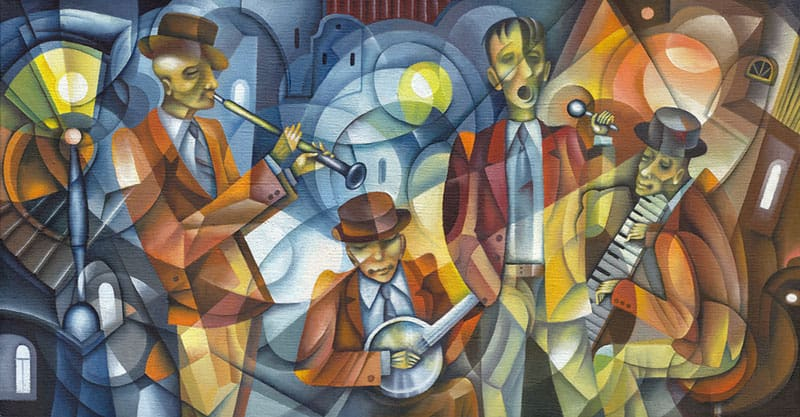



In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.io.sql as sqlio
import psycopg2 as ps
import warnings
warnings.filterwarnings('ignore')

In [339]:
conn2 = ps.connect(dbname="sales",
                   user ="postgres",
                   password ="1234",
                   host = "localhost",
                   port = "5432")


# Data Exploration & General Observation


In [340]:
# See how many tables are there 
sql = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"
df_tables = sqlio.read_sql_query(sql, conn2)

print(df_tables)

        table_name
0           artist
1            album
2         employee
3         customer
4          invoice
5     invoice_line
6            track
7         playlist
8   playlist_track
9            genre
10      media_type


In [341]:
## How many unique song name in track ?
sql = "SELECT COUNT(DISTINCT name) AS track_name_count FROM track;;"
df = pd.read_sql_query(sql, conn2)
df

,track_name_count
0,3257


In [342]:
## How many unique artist name in artist ?
sql = "SELECT COUNT(DISTINCT artist) AS artist_name_count FROM artist;"
df = pd.read_sql_query(sql, conn2)
df

,artist_name_count
0,275


In [343]:
## How many unique artist name in artist ?
sql = "SELECT COUNT(DISTINCT title) AS album_count FROM album;"
df = pd.read_sql_query(sql, conn2)
df

,album_count
0,347


In [344]:
# Total revenue each year
sql = "SELECT SUM(il.unit_price * il.quantity) AS total_sales_revenue, EXTRACT(YEAR FROM i.invoice_date) AS invoice_year FROM invoice_line il JOIN invoice i ON il.invoice_id = i.invoice_id GROUP BY invoice_year ORDER BY invoice_year;"
df = pd.read_sql_query(sql, conn2)
df

,total_sales_revenue,invoice_year
0,449.46,2021.0
1,481.45,2022.0
2,469.58,2023.0
3,477.53,2024.0
4,450.58,2025.0


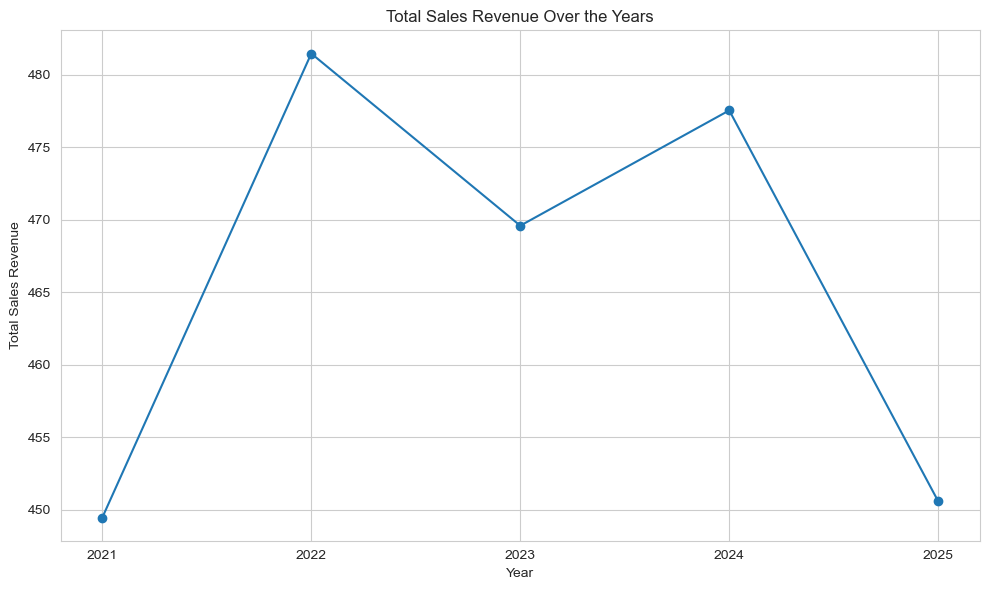

In [345]:
plt.figure(figsize=(10, 6))
plt.plot(df['invoice_year'], df['total_sales_revenue'], marker='o', linestyle='-')
plt.title('Total Sales Revenue Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Sales Revenue')
plt.grid(True)
plt.xticks(df['invoice_year'])  # Using DataFrame columns for ticks
plt.tight_layout()
plt.show()

- 7.12% increase from 2021 to 2022
- 2.47% decrease from 2022 to 2023
- 1.69% increase from 2023 to 2024
- 5.64% decrease from 2024 to 2025 
- Top sales is in 2022 and lowest sales is in 2021

## Genre and Sales


### Which genre customers like the most ?

In [346]:
## Which genre is popular amongst customer
sql  ="SELECT g.name AS genre,COUNT(il.track_id) AS total_purchases FROM invoice_line il JOIN track t ON il.track_id = t.track_id JOIN genre g ON t.genre_id = g.genre_id GROUP BY g.name ORDER BY total_purchases DESC"
df = pd.read_sql_query(sql, conn2)
df

,genre,total_purchases
0,Rock,835
1,Latin,386
2,Metal,264
3,Alternative & Punk,244
4,Jazz,80
5,Blues,61
6,TV Shows,47
7,Classical,41
8,R&B/Soul,41
9,Reggae,30


<Figure size 1000x600 with 0 Axes>

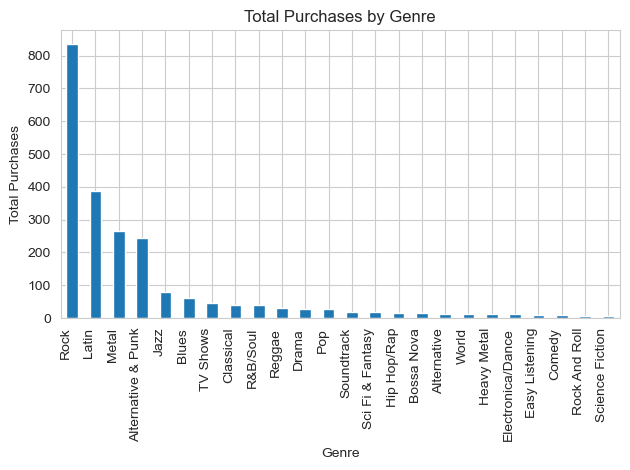

In [347]:
import matplotlib.pyplot as plt

df.set_index('genre', inplace=True)

plt.figure(figsize=(10, 6))
df.plot(kind='bar', legend=None)
plt.title('Total Purchases by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Purchases')
plt.xticks(rotation=90, ha='right') 
plt.tight_layout() 
plt.show()

- Rock, Latin, Metal and Alternative & Punk are the top 4 most bought genres respectively


### What's the trending genre throughout the years ?

In [348]:
sql = "WITH ranked_genres AS (SELECT EXTRACT(YEAR FROM i.invoice_date) AS year, g.name AS genre, COUNT(*) AS track_count, ROW_NUMBER() OVER (PARTITION BY EXTRACT(YEAR FROM i.invoice_date) ORDER BY COUNT(*) DESC) AS genre_rank FROM invoice AS i JOIN invoice_line AS il ON i.invoice_id = il.invoice_id JOIN track AS t ON il.track_id = t.track_id JOIN genre AS g ON t.genre_id = g.genre_id GROUP BY EXTRACT(YEAR FROM i.invoice_date), g.name) SELECT year,genre, track_count FROM ranked_genres WHERE genre_rank <= 3 ORDER BY year, genre_rank;"
df = pd.read_sql_query(sql, conn2)
df

,year,genre,track_count
0,2021.0,Rock,180
1,2021.0,Latin,83
2,2021.0,Alternative & Punk,63
3,2022.0,Rock,157
4,2022.0,Latin,78
5,2022.0,Metal,54
6,2023.0,Rock,158
7,2023.0,Latin,81
8,2023.0,Alternative & Punk,46
9,2024.0,Rock,164


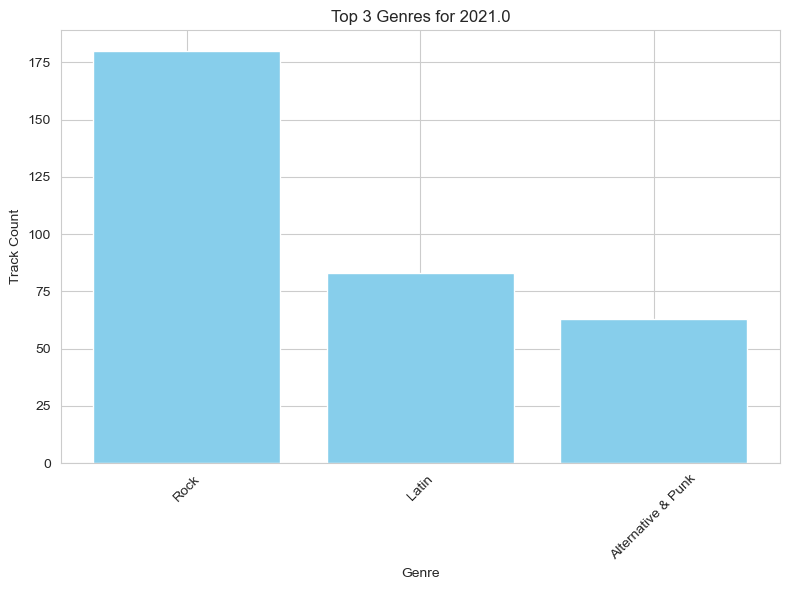

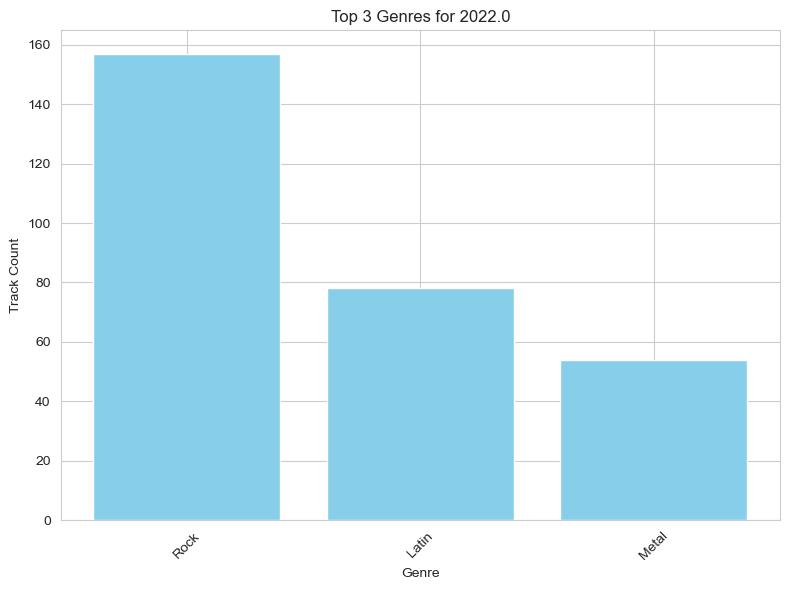

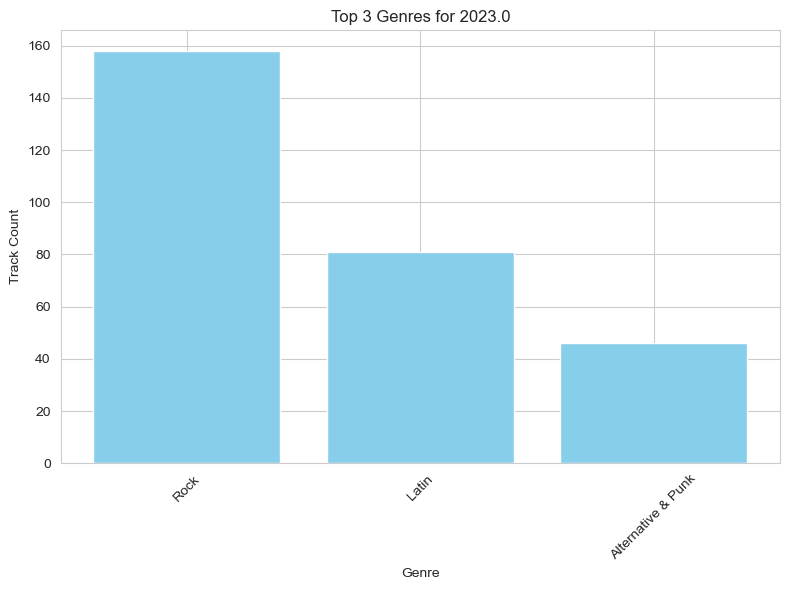

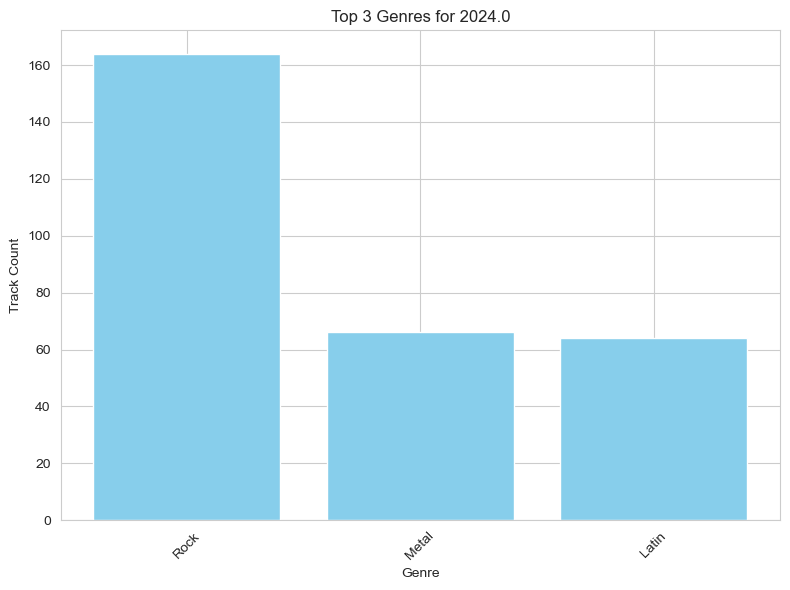

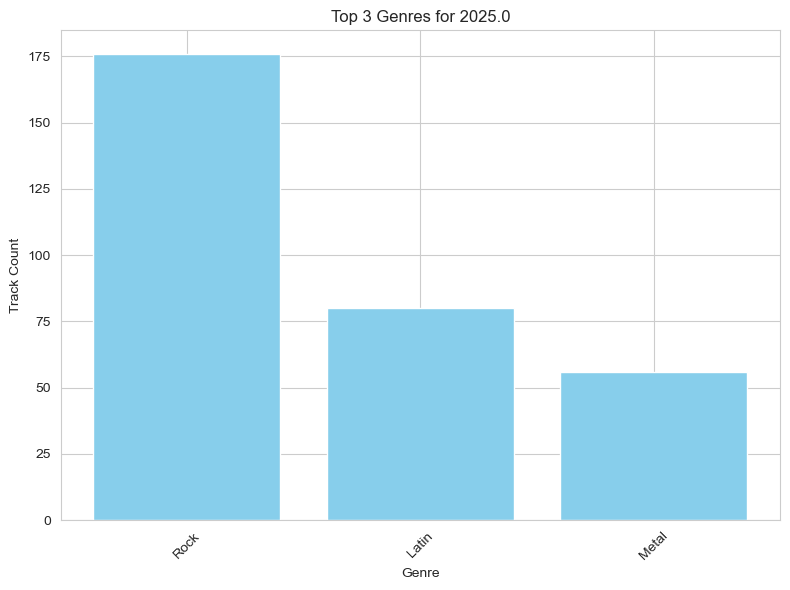

In [349]:
grouped = df.groupby('year')

# Plot top 3 genres for each year
for year, group in grouped:
    top_genres = group.nlargest(3, 'track_count')
    plt.figure(figsize=(8, 6))
    plt.bar(top_genres['genre'], top_genres['track_count'], color='skyblue')
    plt.title(f'Top 3 Genres for {year}')
    plt.xlabel('Genre')
    plt.ylabel('Track Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- Rock is consistently the most popular genre throughout the years 
- Latin is often in 2nd place but Metal was 2nd in 2024 
- While 3rd place is either Alternative & Punk or Metal  

## Country and Sales
### Which country has the most sales ?

In [350]:
sql  = "SELECT billing_country AS country,SUM(total) AS total_sales FROM invoice GROUP BY billing_country ORDER BY total_sales DESC;"
df = pd.read_sql_query(sql, conn2)
df

,country,total_sales
0,USA,523.06
1,Canada,303.96
2,France,195.10
3,Brazil,190.10
4,Germany,156.48
5,United Kingdom,112.86
6,Czech Republic,90.24
7,Portugal,77.24
8,India,75.26
9,Chile,46.62


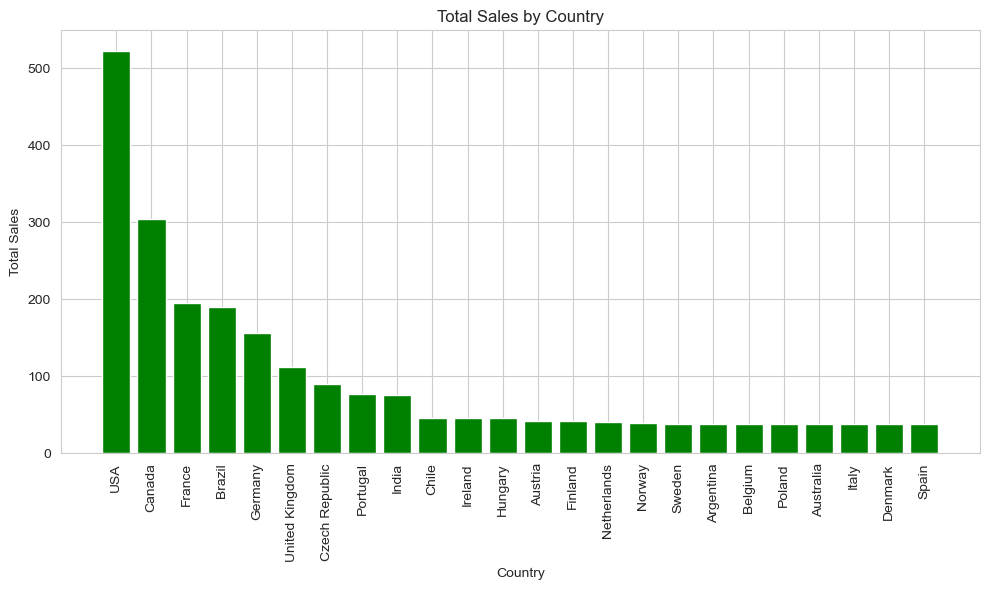

In [351]:
## Visualization of country and the number of sales

plt.figure(figsize=(10, 6))
plt.bar(df['country'], df['total_sales'], color='green')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Total Sales by Country')
plt.xticks(rotation=90)  
plt.tight_layout() 
plt.show()

- USA, Canada, France, Brazil and UK are the top 5 countries with the most sales

In [352]:
sql = "SELECT billing_country, billing_city, COUNT(*) AS total_invoices FROM invoice WHERE billing_country IN ('USA', 'Canada', 'France', 'Brazil', 'Germany') GROUP BY billing_country, billing_city ORDER BY billing_country, billing_city;"
df = pd.read_sql_query(sql, conn2)
df


,billing_country,billing_city,total_invoices
0,Brazil,Brasília,7
1,Brazil,Rio de Janeiro,7
2,Brazil,São José dos Campos,7
3,Brazil,São Paulo,14
4,Canada,Edmonton,7
5,Canada,Halifax,7
6,Canada,Montréal,7
7,Canada,Ottawa,7
8,Canada,Toronto,7
9,Canada,Vancouver,7


- These are the city of the top 5 countries with the most sales
- Therefore, targeted ads can be launch towards those location for more sales 

### Which tracks are sold the most ?

In [353]:
sql = "SELECT t.track_id, t.name AS track_name, SUM(il.quantity) AS total_quantity FROM invoice_line il JOIN track t ON il.track_id = t.track_id GROUP BY t.track_id, t.name ORDER BY total_quantity DESC;"
df = pd.read_sql_query(sql, conn2)
df


,track_id,track_name,total_quantity
0,449,Calling Dr. Love,2
1,2959,Hallelujah Here She Comes,2
2,3177,Hot Girl,2
3,1853,Battery,2
4,867,Açai,2
...,...,...,...
1979,1161,Don't Cry (Original),1
1980,447,Shout It Out Loud,1
1981,1911,I Don't Wanna Be Kissed (By Anyone But You),1
1982,2428,Evil Ways,1


- The total quantity sold for each track have been 2 to 1, therefore we can't determine the which tracks sold the most

In [354]:
sql ="SELECT a.title AS album_title, g.name AS genre, COUNT(il.invoice_id) AS total_albums_sold FROM album a JOIN track t ON a.album_id = t.album_id JOIN genre g ON t.genre_id = g.genre_id JOIN invoice_line il ON t.track_id = il.track_id GROUP BY a.album_id, a.title, g.genre_id, g.name ORDER BY total_albums_sold DESC;"
df = pd.read_sql_query(sql, conn2)
df


,album_title,genre,total_albums_sold
0,Minha Historia,Latin,27
1,Acústico,Alternative & Punk,22
2,Greatest Kiss,Rock,20
3,"Chronicle, Vol. 2",Rock,19
4,Prenda Minha,Latin,19
...,...,...,...
311,Handel: The Messiah (Highlights),Classical,1
312,Muso Ko,World,1
313,English Renaissance,Classical,1
314,"J.S. Bach: Chaconne, Suite in E Minor, Partita...",Classical,1


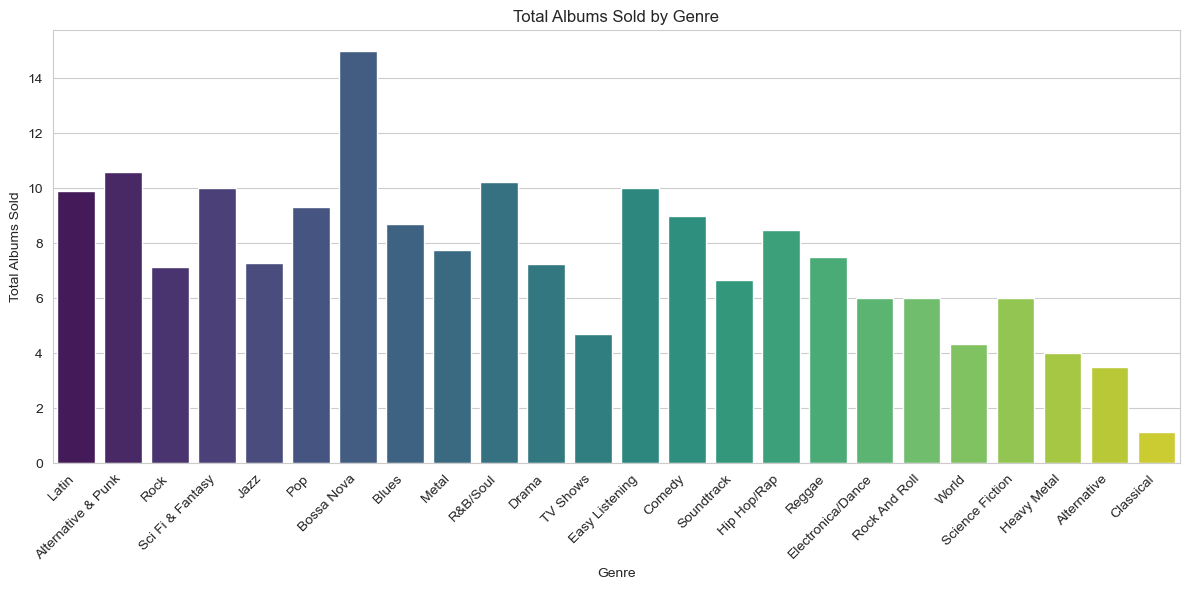

In [355]:
df_sorted = df.sort_values(by='total_albums_sold', ascending=False)

# Create a bar plot using seaborn without error bars
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x='genre', y='total_albums_sold', ci=None, palette='viridis')
plt.title('Total Albums Sold by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Albums Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- In terms of album sales, Bossa Nova, Alternative & Punk, R&B/Soul, Easy Listening and Sci Fi & Fantasy are the top 5 genre most sold 

## Genre, Artist and Customers

In [356]:
sql = "SELECT genre,artist_name AS top_artist, total_tracks_sold FROM (SELECT g.name AS genre, ar.name AS artist_name, COUNT(il.invoice_id) AS total_tracks_sold, ROW_NUMBER() OVER (PARTITION BY g.genre_id ORDER BY COUNT(il.invoice_id) DESC) AS rank FROM genre g JOIN track t ON g.genre_id = t.genre_id JOIN album al ON t.album_id = al.album_id JOIN artist ar ON al.artist_id = ar.artist_id JOIN invoice_line il ON t.track_id = il.track_id GROUP BY g.genre_id, ar.artist_id) AS ranked_artists WHERE rank = 1;"
df = pd.read_sql_query(sql, conn2)
df

,genre,top_artist,total_tracks_sold
0,Rock,U2,91
1,Jazz,Spyro Gyra,20
2,Metal,Metallica,91
3,Alternative & Punk,Titãs,34
4,Rock And Roll,BackBeat,6
5,Blues,Eric Clapton,27
6,Latin,Os Paralamas Do Sucesso,45
7,Reggae,Cidade Negra,16
8,Pop,U2,16
9,Soundtrack,Passengers,9


- These are the top artist for each genre of music 

### Since Rock, Latin, Metal and Alternative & Punk were most popular throughout the years, we'll investigate them further 

In [357]:
sql = "SELECT customer_id, customer_name, genre, total_tracks_bought FROM (SELECT c.customer_id, c.first_name || ' ' || c.last_name AS customer_name, g.name AS genre, COUNT(il.invoice_id) AS total_tracks_bought, ROW_NUMBER() OVER (PARTITION BY g.name ORDER BY COUNT(il.invoice_id) DESC) AS rank FROM customer c JOIN invoice i ON c.customer_id = i.customer_id JOIN invoice_line il ON i.invoice_id = il.invoice_id JOIN track t ON il.track_id = t.track_id JOIN genre g ON t.genre_id = g.genre_id WHERE g.name IN ('Rock', 'Latin', 'Metal', 'Alternative & Punk') GROUP BY c.customer_id, c.first_name, c.last_name, g.name) AS ranked_customers WHERE rank <= 5;"
df = pd.read_sql_query(sql, conn2)
df

,customer_id,customer_name,genre,total_tracks_bought
0,8,Daan Peeters,Alternative & Punk,14
1,47,Lucas Mancini,Alternative & Punk,11
2,39,Camille Bernard,Alternative & Punk,10
3,30,Edward Francis,Alternative & Punk,9
4,56,Diego Gutiérrez,Alternative & Punk,9
5,12,Roberto Almeida,Latin,16
6,11,Alexandre Rocha,Latin,16
7,52,Emma Jones,Latin,15
8,32,Aaron Mitchell,Latin,14
9,20,Dan Miller,Latin,14


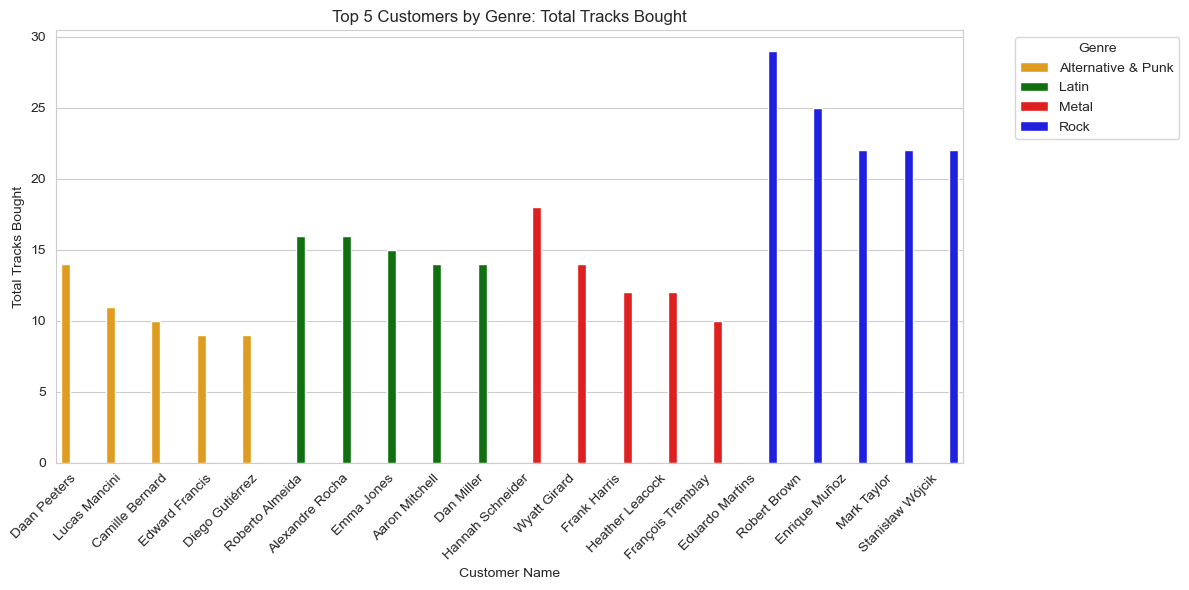

In [358]:
palette = {'Rock': 'blue', 'Latin': 'green', 'Metal': 'red', 'Alternative & Punk': 'orange'}

df_sorted = df.sort_values(by=['genre', 'total_tracks_bought'], ascending=[True, False])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x='customer_name', y='total_tracks_bought', hue='genre', palette=palette)
plt.title('Top 5 Customers by Genre: Total Tracks Bought')
plt.xlabel('Customer Name')
plt.ylabel('Total Tracks Bought')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- These are the customers that bought the most track for each genre
- The company could send discount/promotion/targeted ads for those individuals 

## Conclusion & Key Findings
- USA, Canada, France, Brazil and UK are the top 5 countries with the most sales
- Rock, Latin, Metal and Alternative & Punk are the top 4 most bought genres respectively
- Trending genres from 2021 - 2025 tend to be Rock, Latin, Metal and Alternative & Punk  
- Go to "Genre,Artist and Customers" to find the top artist for each respective journal

## Reference:
- https://rstudio-pubs-static.s3.amazonaws.com/636199_e04ca0dded894c23a17066dfad6ec9d3.html